In [1]:
import torch 
from d2l import torch as d2l
from IPython import display

In [2]:
batch_size = 256
train_iter , test_iter = d2l.load_data_fashion_mnist(batch_size)

3.6.1 初始化模型参数

In [3]:
num_inputs = 784 # 28*28
num_outputs = 10

w = torch.normal(0, 0.01 , size=(num_inputs , num_outputs) , requires_grad =True)
b = torch.zeros(num_outputs, requires_grad=True)

3.6.2 定义softmax操作

In [4]:
def softmax(X):
    x_exp = torch.exp(X)
    partition = x_exp.sum(1, keepdim=True  )
    return x_exp / partition

In [5]:
x = torch.normal(0 ,1 , (2, 5))
x_prob = softmax(x)
x_prob , x_prob.sum(1)

(tensor([[0.4415, 0.2457, 0.0651, 0.1519, 0.0958],
         [0.2160, 0.0323, 0.1273, 0.2023, 0.4221]]),
 tensor([1., 1.]))

3.6.3 定义模型

In [6]:
def net(X):
    print()
    return softmax(torch.matmul(X.reshape(-1, w.shape[0]),  w) + b)

3.6.4 定义损失函数

In [7]:
y  = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# [0 ,1 ] 是一个索引，从零开始所有的，y是正确的标签，
# 这样可以直接索引到正确的标签的 y_hat
y_hat[[0,1], y]

tensor([0.1000, 0.5000])

In [8]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)


tensor([2.3026, 0.6931])

3.6.5 分类精度

In [9]:
def accuracy(y_hat, y):
    '''计算正确的数量'''
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        # aegmax 获取最最大值的索引
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float( cmp.type(y.dtype).sum() )

In [ ]:
accuracy(y_hat, y ) / len(y)

0.5

In [11]:
def evaluate_accuracy(net, data_iter):
    '''计算在特定数据集上的正确率'''
    
    if  isinstance(net, torch.nn.Module):
        net.eval()
     # 累加器
    
    metric = d2l.Accumulator(2)
      
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    
    return metric[0] / metric[1]

In [12]:
evaluate_accuracy(net, test_iter)
# 会出现大量空行


0.0724

3.6.6. 训练模型

In [13]:
def train_epoch_ch3(net, train_iter, loss, updater):
    '''训练一个迭代周期'''
    # 将模型设为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和， 训练准确度总和， 样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat, y), y.numel() )
    #返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [14]:
class Animator:
    '''在动画中绘制数据'''
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
    

In [15]:
def train_ch3(net, train_iter, test_iter, loss, num_eopch, updater):
    '''训练模型'''
    anitmator = d2l.Animator(xlabel='epoch', xlim = [1, num_eopch], ylim = [0.3,0.9],
                         legend = ['train_loss', 'train_acc', 'test_acc'])
    for epoch in range(num_eopch):
        train_metrics =  train_epoch_ch3(net,train_iter=train_iter,loss=loss,updater=updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        anitmator.add(epoch+1 , train_metrics   +(test_acc,)) #  拼接元组
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc < 1 and train_acc >0.7 ,train_acc
    assert test_acc < 1 and test_acc > 0.7 , test_acc


In [16]:
lr = 0.1 

def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

KeyboardInterrupt: 

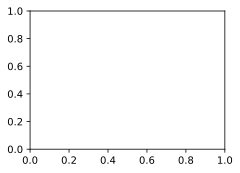

In [17]:
num_eopchs = 10
train_ch3(net, train_iter, test_iter, cross_entropy , num_eopchs, updater)

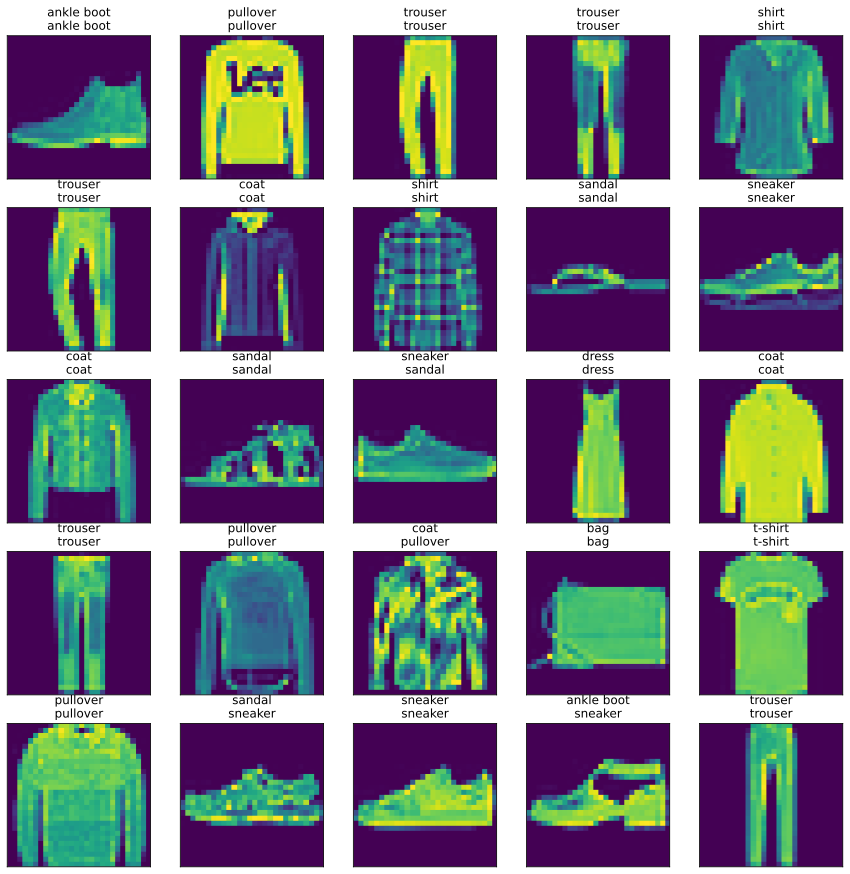

In [19]:
def predict_ch3(net , test_iter, m = 5, n =5):
    '''预测标签'''
    for X , y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis = 1))

    titles = [true + '\n' + pred for true , pred in zip(trues, preds)]
    d2l.show_images(X[0:n*m].reshape((n*m, 28, 28)), m , n ,titles=titles,scale= 3)

predict_ch3(net, test_iter)